# Question 2:  Pose Graph Optimization for 2D SLAM

## Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

## Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:

1. Initial position
2. Odometry Contraints/Edges: This "edge" information tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges: Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` (in `data/`) which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://saishubodh.notion.site/G2O-Edge-Types-d9f9ff63c77c4ceeb84b1e49085004e3) ). The ground truth is `gt.txt`.

## Steps:

### Part 1

Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](../misc/robot-poses-MR-P1.png)

(Use `draw()` helper function or `g2o_viewer` or `EVO`)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import os
import jax.numpy as jnp
import jax

In [2]:
def read_vertex(fname):

    x_arr = []
    y_arr = []
    theta_arr = []

    for line in open(fname):
        if "VERTEX_SE2" in line:
            gg = line.split()
            x_arr.append(float(gg[2]))
            y_arr.append(float(gg[3]))
            theta_arr.append(float(gg[4].rstrip('\n')))
            
    vertex = jnp.array([x_arr, y_arr, theta_arr])
    return vertex

def read_edge(fname):

    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []

    for line in open(fname):
        if "EDGE_SE2" in line:
            gg = line.split()
            ind1_arr.append(int(gg[1]))
            ind2_arr.append(int(gg[2]))
            del_x.append(float(gg[3]))
            del_y.append(float(gg[4]))
            del_theta.append(float(gg[5]))
            
    edges = [jnp.array(ind1_arr), jnp.array(ind2_arr), jnp.array(del_x), jnp.array(del_y), jnp.array(del_theta)]
    return edges
            
vertex = read_vertex('../data/edges.txt')
edges = read_edge('../data/edges.txt')

print("Starting vertex is ["+str(vertex[0][0])+", "+str(vertex[1][0])+", "+str(vertex[2][0])+"].")
print("Got "+str(edges[0].size)+" edges in total.")

Starting vertex is [-5.0, -8.0, 0.0].
Got 139 edges in total.


In [3]:
# Taken from helper code

def draw(X, Y, THETA):
    plt.clf()
    ax = plt.subplot(111)
    ax.plot(X, Y, 'bo')
    plt.plot(X, Y, 'c-')
    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'r->')
    plt.show()

Odometry: 


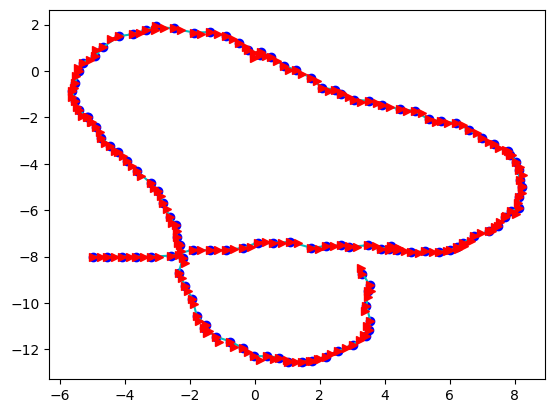

Ground truth: 


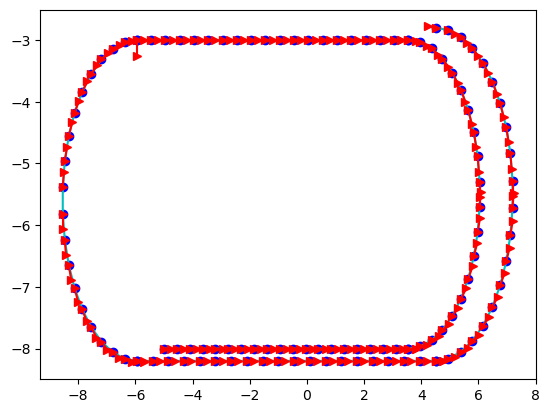

In [4]:
x = vertex[0][0]
y = vertex[1][0]
theta = vertex[2][0]
pose = [x, y, theta]
pose = jnp.array(pose)
poses = [pose]

for i in range(edges[0].size):
    
    if abs(edges[0][i] - edges[1][i]) != 1:
        pass
    
    else:
        del_x = edges[2][i]
        del_y = edges[3][i]
        del_theta = edges[4][i]
        x_new = x + del_x * jnp.cos(theta) - del_y * jnp.sin(theta)
        y_new = y + del_y * jnp.cos(theta) + del_x * jnp.sin(theta)
        theta_new = theta + del_theta
        x = x_new
        y = y_new
        theta = theta_new
        pose = [x, y, theta]
        pose = jnp.array(pose)
        poses.append(pose)
        
poses = jnp.array(poses)

print("Odometry: ")
draw(poses[:,0], poses[:,1], poses[:,2])

vertex1 = read_vertex('../data/gt.txt')
vertex1 = jnp.array(vertex1)
vertex1 = vertex1.T
print("Ground truth: ")
draw(vertex1[:,0], vertex1[:,1], vertex1[:,2])

In [5]:
with open('edges-poses.g2o', 'w') as f:
    for i in range(poses.shape[0]):
        ind = i
        x = poses[i][0]
        y = poses[i][1]
        theta = poses[i][2]
        ln = "VERTEX_SE2 " + str(ind) + " " + str(x) + " " + str(y) + " " + str(theta)
        f.write("%s\n" % ln)
        
    for line in open('../data/edges.txt'):
        if "VERTEX_SE2" not in line:
            f.write("%s" % line)
                
f.close()

## Part 2

Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster. You can also visualise your Jacobian and see the structure of the matrix (just use `plt.imshow`).

**Regarding LM iterations, stopping criterion, information matrix values.**

1. As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notes on non-linear LS)](https://saishubodh.notion.site/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).

2. You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

3. You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this project. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (seen later on), you will be getting a close to ground truth trajectory.

In [6]:
def draw_traj(X, Y, THETA):
    
    plt.clf()
    
    ax = plt.subplot(111)
    ax.plot(X, Y, 'bo')
    plt.plot(X, Y, 'c-')
    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'g->')
        
        
    vertex1 = read_vertex('edges-poses.g2o')
    vertex1 = jnp.array(vertex1)
    vertex1 = vertex1.T
    
    X = vertex1[:,0]
    Y = vertex1[:,1]
    Z = vertex1[:,2]
    
    ax = plt.subplot(111)
    ax.plot(X, Y, 'bo')
    plt.plot(X, Y, 'c-')
    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'b->')    
    
    
    vertex1 = read_vertex('../data/gt.txt')
    vertex1 = jnp.array(vertex1)
    vertex1 = vertex1.T
    
    X = vertex1[:,0]
    Y = vertex1[:,1]
    Z = vertex1[:,2]
    
    ax = plt.subplot(111)
    ax.plot(X, Y, 'bo')
    plt.plot(X, Y, 'c-')
    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'r->')
        
    color = ["red", "blue", "green"]
    label = ["Ground Truth", "Initial Estimate", "After optimization"]
        
    l0 = mpatches.Patch(color=color[0], label=label[0])
    l1 = mpatches.Patch(color=color[1], label=label[1])
    l2 = mpatches.Patch(color=color[2], label=label[2])
    plt.legend(handles=[l0, l1, l2])
    plt.show()

In [7]:
def jacobian(current_poses, edges):
    num_constraints = 3 + 3*edges[0].size
    num_variables = 3*current_poses.shape[0]
    
    J = jnp.zeros((num_constraints, num_variables))
        
    J = jax.ops.index_update(
            J, 
            jax.ops.index[:3, :3], 
            jnp.eye(3)
            )
    
    for i in range(edges[0].size):

        del_x = edges[2][i]
        del_y = edges[3][i]
        del_theta = edges[4][i]
        
        start_row = 3 + 3*i
        
        # This is for the subtraction
        # There are three -1 terms, one each for x, y, theta
        J = jax.ops.index_update(
                J,
                jax.ops.index[start_row : 3 + start_row, edges[1][i]*3: 3 + edges[1][i]*3],
                -1 * jnp.eye(3)
            )
        
        # This is for the transformation
        # There are 5 terms in total, 1 wrt x, 1 wrt y, and 3 wrt theta
        pos_update = jnp.eye(3)
        pos_update = jax.ops.index_update(pos_update, 
                                      jax.ops.index[0, 2], 
                                      - del_x * jnp.sin(poses[edges[0][i]][3]) - del_y * jnp.cos(poses[edges[0][i]][3]))    
        pos_update = jax.ops.index_update(pos_update, 
                                      jax.ops.index[1, 2], 
                                      - del_y * jnp.sin(poses[edges[0][i]][3]) + del_x * jnp.cos(poses[edges[0][i]][3]))
        J = jax.ops.index_update(
                J,
                jax.ops.index[start_row : 3 + start_row, edges[0][i]*3: 3 + edges[0][i]*3],
                pos_update
            )
    
    return J

def residual(current_poses, edges, start_point):
    
    residue = []
    residue.extend(list(current_poses[0] - start_point))

    for i in range(edges[0].size):
        [x, y, theta] = current_poses[edges[0][i]]
        del_x = edges[2][i]
        del_y = edges[3][i]
        del_theta = edges[4][i]
        x_new = x + del_x * jnp.cos(theta) - del_y * jnp.sin(theta)
        y_new = y + del_y * jnp.cos(theta) + del_x * jnp.sin(theta)
        theta_new = theta + del_theta
        residue.extend([float(x_new)-current_poses[edges[1][i]][0], 
                        float(y_new)-current_poses[edges[1][i]][1], 
                        float(theta_new)-current_poses[edges[1][i]][2]])
    
    return jnp.asarray(residue)

In [8]:
def optimise_lm(poses, edges, start_point, max_itr, odo_certainity, loop_certainity, start_certainity, plt_flg):
    
    lamda = 1
    tol = 1e-6
    all_errors = []
    
    certainities = [start_certainity, start_certainity, start_certainity]
    
    for i in range(edges[0].size):
        if abs(edges[0][i]-edges[1][i]) != 1:
            certainities.append(loop_certainity)
            certainities.append(loop_certainity)
            certainities.append(loop_certainity)
        else:
            certainities.append(odo_certainity)
            certainities.append(odo_certainity)
            certainities.append(odo_certainity)   
            
    weights = jnp.diag(jnp.array(certainities))
    
    all_poses = [poses]
    
    res = residual(poses, edges, start_point)
    err = 0.5 * res.T@weights@res
    all_errors.append(err) 

    print('Iteration: 0')
    print('Error: '+str(err))
    draw_traj(poses[:, 0], poses[:, 1], poses[:, 2])
    
    for _ in range(max_itr):

        J = jacobian(poses, edges)
        res = residual(poses, edges, start_point)
        step = - jnp.linalg.inv(J.T @ weights @ J + lamda * jnp.eye(J.shape[1])) @ J.T @ weights.T @ res
        new_poses = poses + step.reshape((-1, 3))
    
        res = residual(poses, edges, start_point)
        err = 0.5 * (res.T@weights@res)
        
        print('Iteration: '+str(_+1))
        print('Error: '+str(err))
        
        if (_+1)%10==0 or _+1==max_itr and plt_flg==True:
            draw_traj(new_poses[:, 0], new_poses[:, 1], new_poses[:, 2])
        else:
            print()

        if len(all_errors) > 0:
            if (err > all_errors[-1]):
                lamda = lamda * 2
            else:
                lamda = lamda / 3
                
        all_errors.append(err)
        all_poses.append(new_poses)
        
        if err < 40 or jnp.linalg.norm(new_poses - poses) < tol:
            if plt_flg==True:
                draw_traj(new_poses[:, 0], new_poses[:, 1], new_poses[:, 2])
            poses = new_poses
            break
        
        poses = new_poses
        
    return all_poses, all_errors

Iteration: 0
Error: 639372.0


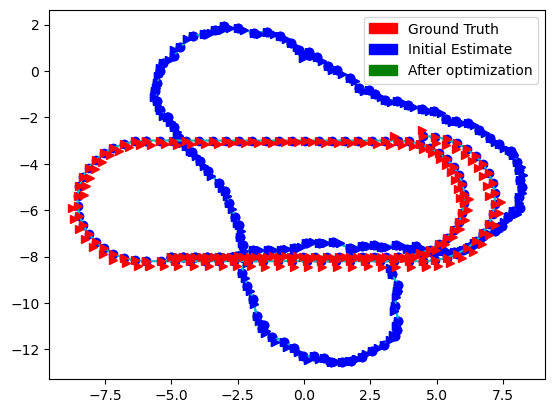

Iteration: 1
Error: 639372.0

Iteration: 2
Error: 90723.35

Iteration: 3
Error: 8810.025

Iteration: 4
Error: 6317.4224

Iteration: 5
Error: 4765.926

Iteration: 6
Error: 2929.7542

Iteration: 7
Error: 2137.967

Iteration: 8
Error: 2058.0308

Iteration: 9
Error: 2539.3298

Iteration: 10
Error: 2806.6997


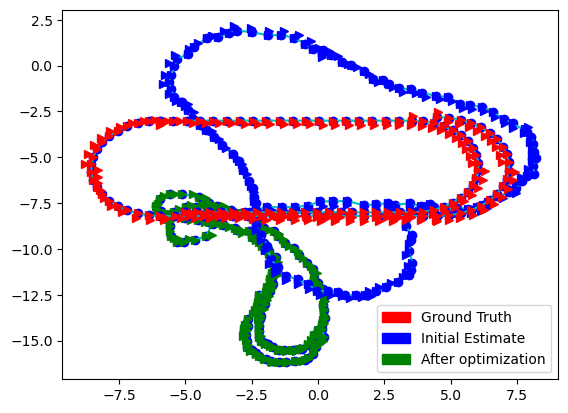

Iteration: 11
Error: 2065.9736

Iteration: 12
Error: 1256.5599

Iteration: 13
Error: 924.48425

Iteration: 14
Error: 798.47906

Iteration: 15
Error: 743.37775

Iteration: 16
Error: 717.6239

Iteration: 17
Error: 705.39246

Iteration: 18
Error: 698.99225

Iteration: 19
Error: 694.05396

Iteration: 20
Error: 688.0046


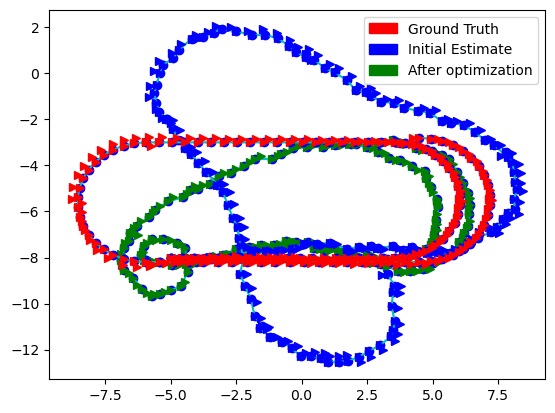

Iteration: 21
Error: 679.67596

Iteration: 22
Error: 669.23376

Iteration: 23
Error: 657.9167

Iteration: 24
Error: 647.3763

Iteration: 25
Error: 638.87933

Iteration: 26
Error: 632.9175

Iteration: 27
Error: 629.4841

Iteration: 28
Error: 628.54443

Iteration: 29
Error: 630.01166

Iteration: 30
Error: 633.1823


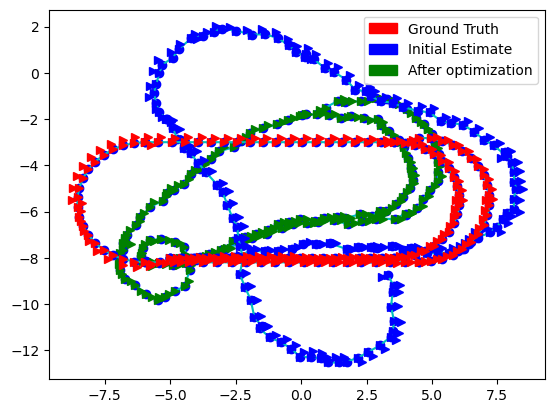

Iteration: 31
Error: 636.3366

Iteration: 32
Error: 637.29

Iteration: 33
Error: 634.837

Iteration: 34
Error: 629.804

Iteration: 35
Error: 624.2053

Iteration: 36
Error: 619.09235

Iteration: 37
Error: 614.32275

Iteration: 38
Error: 611.3961

Iteration: 39
Error: 615.11755

Iteration: 40
Error: 630.0585


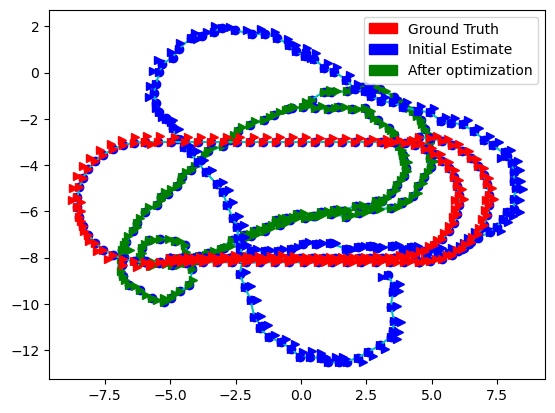

Iteration: 41
Error: 654.1408

Iteration: 42
Error: 675.74805

Iteration: 43
Error: 680.3765

Iteration: 44
Error: 667.46313

Iteration: 45
Error: 659.28687

Iteration: 46
Error: 671.57965

Iteration: 47
Error: 677.182

Iteration: 48
Error: 647.23315

Iteration: 49
Error: 615.75006

Iteration: 50
Error: 655.2531


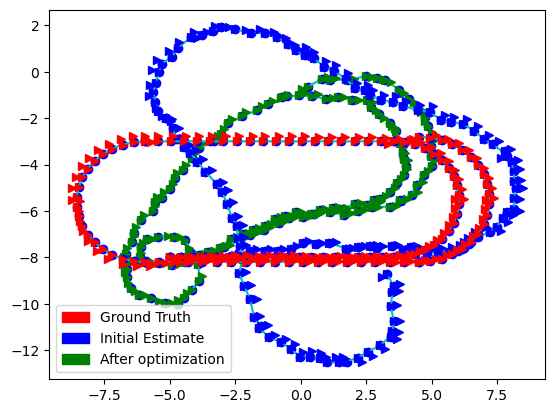

Iteration: 51
Error: 813.0639

Iteration: 52
Error: 1074.1492

Iteration: 53
Error: 1320.0743

Iteration: 54
Error: 1315.4532

Iteration: 55
Error: 1067.0399

Iteration: 56
Error: 1374.1469

Iteration: 57
Error: 2214.9685

Iteration: 58
Error: 2070.837

Iteration: 59
Error: 1302.0677

Iteration: 60
Error: 941.1831


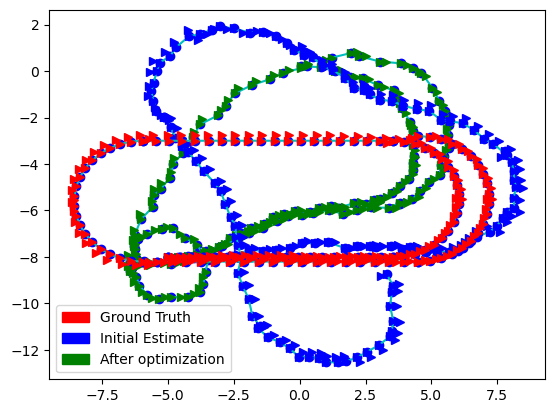

Iteration: 61
Error: 1356.3428

Iteration: 62
Error: 2807.8796

Iteration: 63
Error: 6202.092

Iteration: 64
Error: 12756.058

Iteration: 65
Error: 16810.13

Iteration: 66
Error: 8728.531

Iteration: 67
Error: 4793.415

Iteration: 68
Error: 5248.154

Iteration: 69
Error: 6123.7686

Iteration: 70
Error: 7237.086


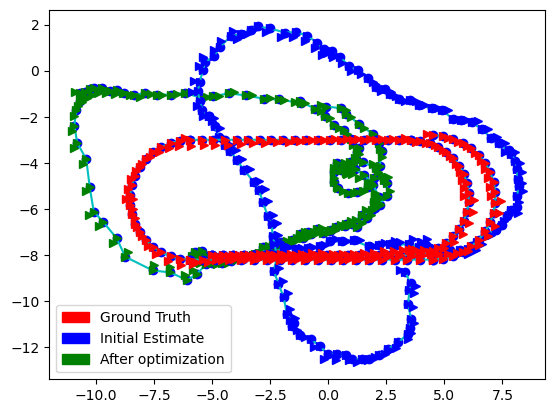

Iteration: 71
Error: 8130.549

Iteration: 72
Error: 4467.796

Iteration: 73
Error: 4515.137

Iteration: 74
Error: 5200.426

Iteration: 75
Error: 4733.729

Iteration: 76
Error: 3413.2288

Iteration: 77
Error: 2046.1151

Iteration: 78
Error: 1184.3323

Iteration: 79
Error: 858.3189

Iteration: 80
Error: 787.26746


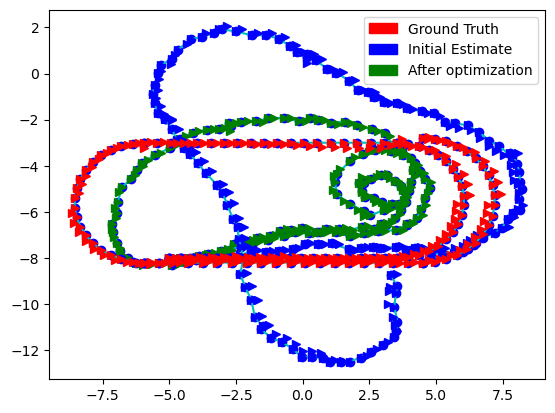

In [9]:
odo_certainity = 500
loop_certainity = 700
start_certainity = 1000
max_itr = 80

poses_history, errors_history = optimise_lm(poses, 
                                            edges, 
                                            poses[0, :], 
                                            max_itr, 
                                            odo_certainity, 
                                            loop_certainity, 
                                            start_certainity,
                                            True)


Results for Information values = 500, 700, 1000


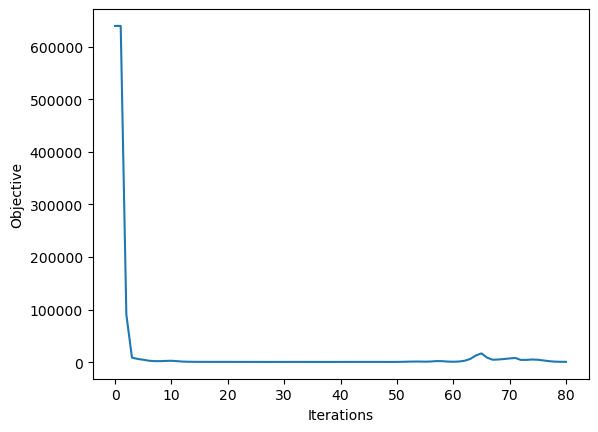


Best result:
Error: 611.3961


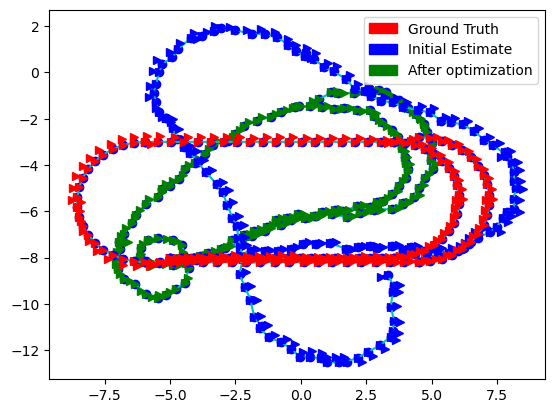

In [12]:
print("\nResults for Information values = 500, 700, 1000")
plt.clf()
plt.plot(errors_history)
plt.xlabel('Iterations')
plt.ylabel('Objective')
plt.show()
best = jnp.argmin(jnp.asarray(errors_history))
print("\nBest result:")
print("Error: "+str(errors_history[best]))
draw_traj(poses_history[best][:, 0], poses_history[best][:, 1], poses_history[best][:, 2])

Iteration: 0
Error: 639372.0


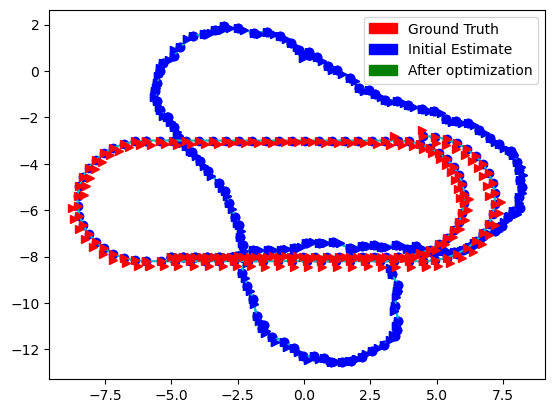

Iteration: 1
Error: 639372.0

Iteration: 2
Error: 75415.23

Iteration: 3
Error: 3986.1045

Iteration: 4
Error: 3211.7466

Iteration: 5
Error: 3089.0164

Iteration: 6
Error: 2030.1215

Iteration: 7
Error: 1391.8522

Iteration: 8
Error: 1487.5486

Iteration: 9
Error: 1953.4525

Iteration: 10
Error: 1901.0723


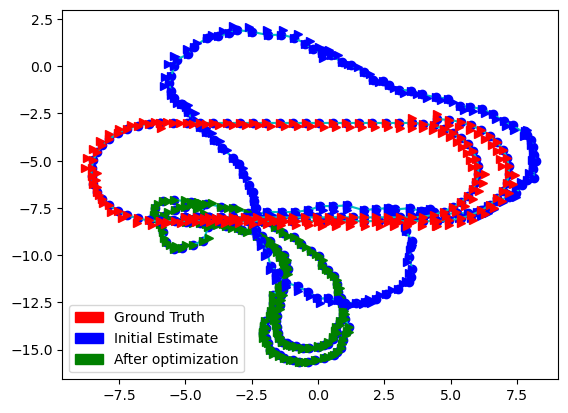

Iteration: 11
Error: 1139.816

Iteration: 12
Error: 611.5798

Iteration: 13
Error: 410.19357

Iteration: 14
Error: 339.11554

Iteration: 15
Error: 315.30756

Iteration: 16
Error: 308.95795

Iteration: 17
Error: 308.516

Iteration: 18
Error: 308.7174

Iteration: 19
Error: 306.92975

Iteration: 20
Error: 302.1451


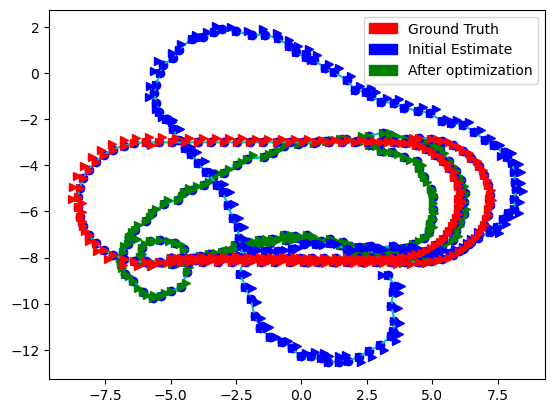

Iteration: 21
Error: 294.7198

Iteration: 22
Error: 286.0857

Iteration: 23
Error: 278.04922

Iteration: 24
Error: 271.89883

Iteration: 25
Error: 267.95444

Iteration: 26
Error: 265.9388

Iteration: 27
Error: 265.64377

Iteration: 28
Error: 267.03024

Iteration: 29
Error: 269.64145

Iteration: 30
Error: 272.13293


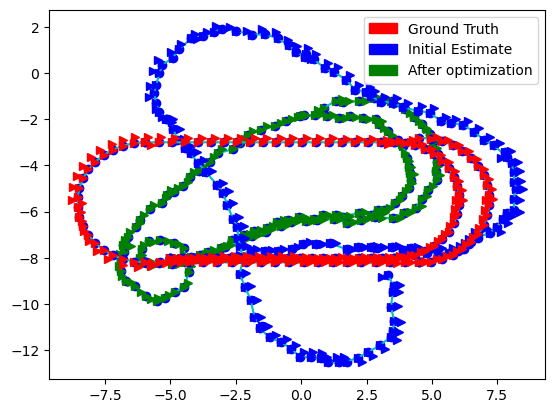

Iteration: 31
Error: 272.7539

Iteration: 32
Error: 270.7735

Iteration: 33
Error: 267.48575

Iteration: 34
Error: 264.98358

Iteration: 35
Error: 263.3973

Iteration: 36
Error: 260.87796

Iteration: 37
Error: 257.7394

Iteration: 38
Error: 258.7272

Iteration: 39
Error: 268.88135

Iteration: 40
Error: 286.94757


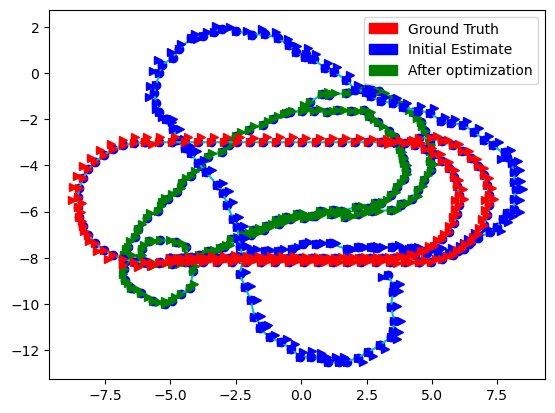

Iteration: 41
Error: 302.7711

Iteration: 42
Error: 303.53845

Iteration: 43
Error: 290.6896

Iteration: 44
Error: 290.30774

Iteration: 45
Error: 318.32388

Iteration: 46
Error: 334.77658

Iteration: 47
Error: 303.3431

Iteration: 48
Error: 265.81046

Iteration: 49
Error: 289.67303

Iteration: 50
Error: 408.87073


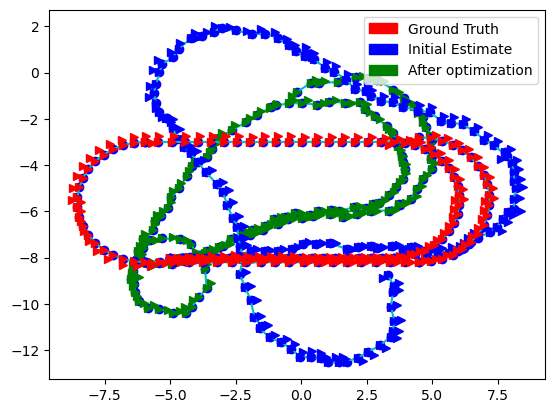

Iteration: 51
Error: 611.4539

Iteration: 52
Error: 808.46136

Iteration: 53
Error: 795.957

Iteration: 54
Error: 524.79285

Iteration: 55
Error: 764.8959

Iteration: 56
Error: 1688.4274

Iteration: 57
Error: 1492.7672

Iteration: 58
Error: 723.7324

Iteration: 59
Error: 422.72778

Iteration: 60
Error: 642.95575


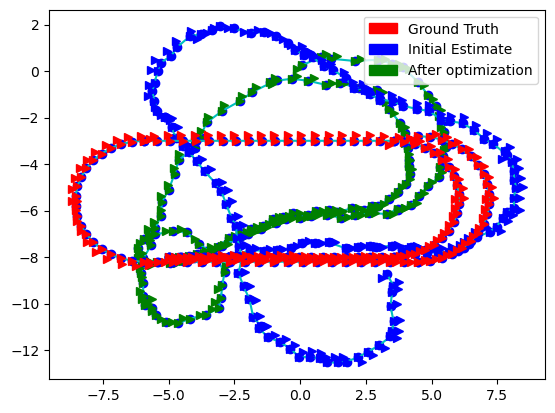

Iteration: 61
Error: 1511.3057

Iteration: 62
Error: 3585.8933

Iteration: 63
Error: 7921.692

Iteration: 64
Error: 12242.868

Iteration: 65
Error: 7551.4155

Iteration: 66
Error: 3234.0107

Iteration: 67
Error: 3220.224

Iteration: 68
Error: 3660.1768

Iteration: 69
Error: 3898.2622

Iteration: 70
Error: 2392.2983


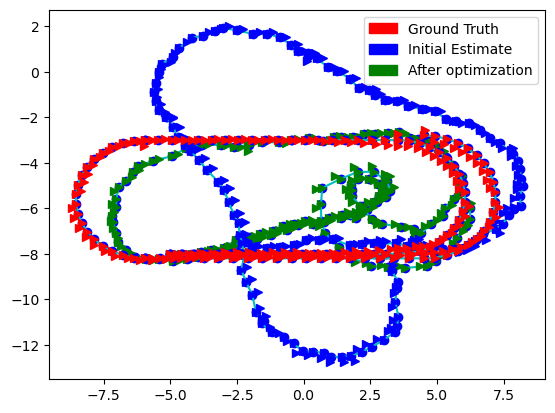

Iteration: 71
Error: 2821.4324

Iteration: 72
Error: 3685.5376

Iteration: 73
Error: 3470.3855

Iteration: 74
Error: 2549.2693

Iteration: 75
Error: 1538.3894

Iteration: 76
Error: 810.39294

Iteration: 77
Error: 465.52292

Iteration: 78
Error: 357.63232

Iteration: 79
Error: 333.12476

Iteration: 80
Error: 328.30185


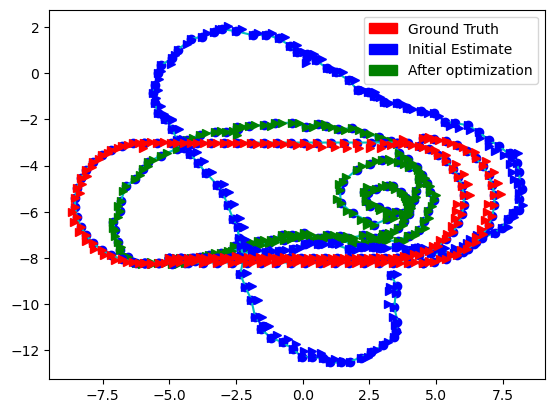

In [13]:
odo_certainity = 200
loop_certainity = 700
start_certainity = 1000
max_itr = 80

poses_history, errors_history = optimise_lm(poses, 
                                            edges, 
                                            poses[0, :], 
                                            max_itr, 
                                            odo_certainity, 
                                            loop_certainity, 
                                            start_certainity,
                                            True)


Results for Information values = 200, 700, 1000


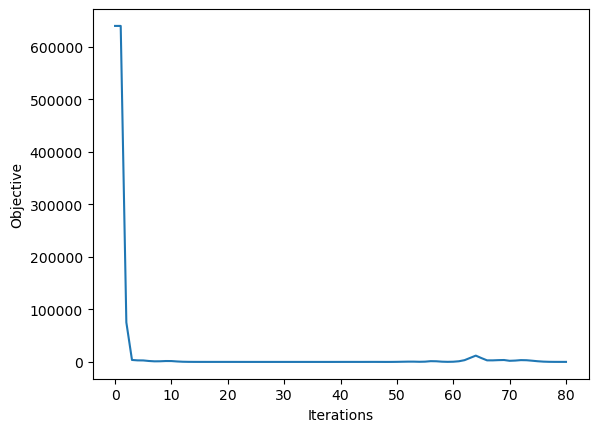


Best result:
Error: 257.7394


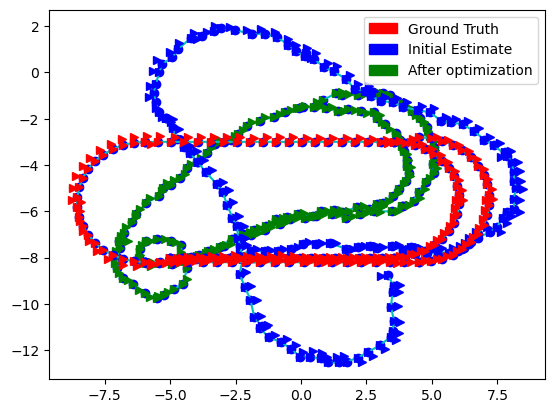

In [15]:
print("\nResults for Information values = 200, 700, 1000")
plt.clf()
plt.plot(errors_history)
plt.xlabel('Iterations')
plt.ylabel('Objective')
plt.show()
best = jnp.argmin(jnp.asarray(errors_history))
print("\nBest result:")
print("Error: "+str(errors_history[best]))
draw_traj(poses_history[best][:, 0], poses_history[best][:, 1], poses_history[best][:, 2])

Iteration: 0
Error: 4566943.0


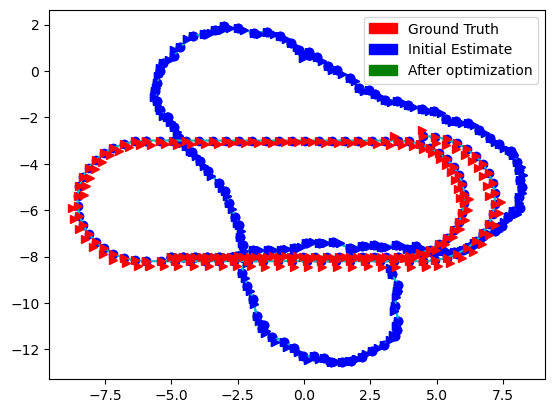

Iteration: 1
Error: 4566943.0

Iteration: 2
Error: 405937.2

Iteration: 3
Error: 16019.533

Iteration: 4
Error: 13828.018

Iteration: 5
Error: 10990.709

Iteration: 6
Error: 7821.1074

Iteration: 7
Error: 6177.3306

Iteration: 8
Error: 7167.8354

Iteration: 9
Error: 9715.538

Iteration: 10
Error: 9395.2


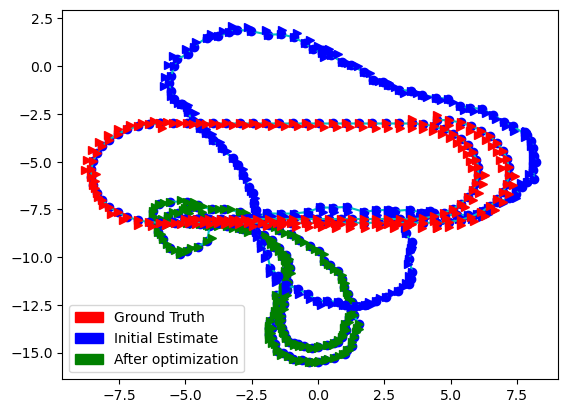

Iteration: 11
Error: 5433.266

Iteration: 12
Error: 2541.3726

Iteration: 13
Error: 1388.0006

Iteration: 14
Error: 1000.7664

Iteration: 15
Error: 894.1535

Iteration: 16
Error: 883.62787

Iteration: 17
Error: 898.4492

Iteration: 18
Error: 908.30145

Iteration: 19
Error: 899.9716

Iteration: 20
Error: 870.76


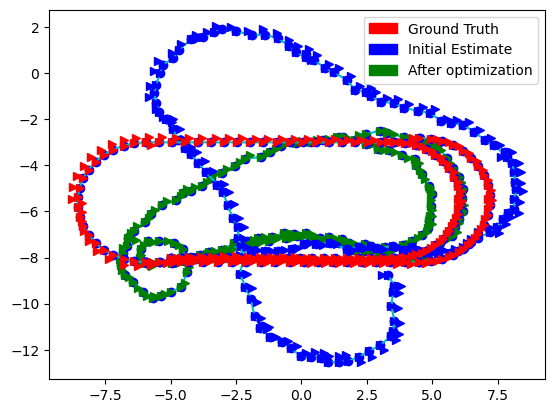

Iteration: 21
Error: 826.40204

Iteration: 22
Error: 778.1643

Iteration: 23
Error: 737.39453

Iteration: 24
Error: 709.9723

Iteration: 25
Error: 695.17426

Iteration: 26
Error: 689.7773

Iteration: 27
Error: 692.1706

Iteration: 28
Error: 701.62024

Iteration: 29
Error: 714.25226

Iteration: 30
Error: 721.7605


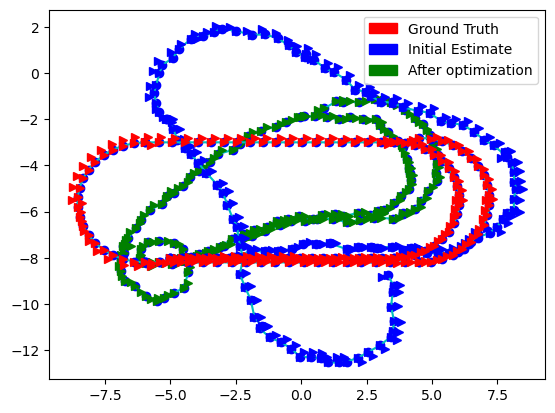

Iteration: 31
Error: 716.6983

Iteration: 32
Error: 701.2999

Iteration: 33
Error: 688.8492

Iteration: 34
Error: 689.00287

Iteration: 35
Error: 691.90955

Iteration: 36
Error: 680.98816

Iteration: 37
Error: 664.44446

Iteration: 38
Error: 675.9504

Iteration: 39
Error: 736.9443

Iteration: 40
Error: 822.6893


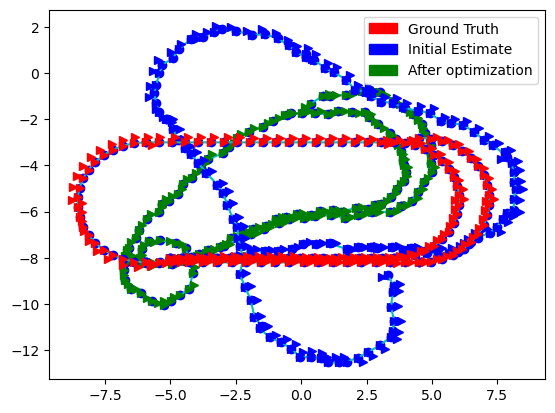

Iteration: 41
Error: 865.4099

Iteration: 42
Error: 815.2566

Iteration: 43
Error: 746.0205

Iteration: 44
Error: 840.3297

Iteration: 45
Error: 1073.3782

Iteration: 46
Error: 1097.295

Iteration: 47
Error: 839.8464

Iteration: 48
Error: 685.906

Iteration: 49
Error: 951.89655

Iteration: 50
Error: 1698.3168


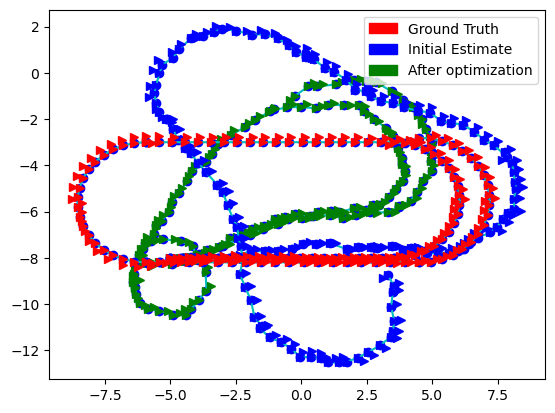

Iteration: 51
Error: 2717.422

Iteration: 52
Error: 3323.06

Iteration: 53
Error: 2476.5332

Iteration: 54
Error: 1267.5966

Iteration: 55
Error: 4677.3687

Iteration: 56
Error: 8857.358

Iteration: 57
Error: 5138.999

Iteration: 58
Error: 1617.3977

Iteration: 59
Error: 1270.1472

Iteration: 60
Error: 3411.4336


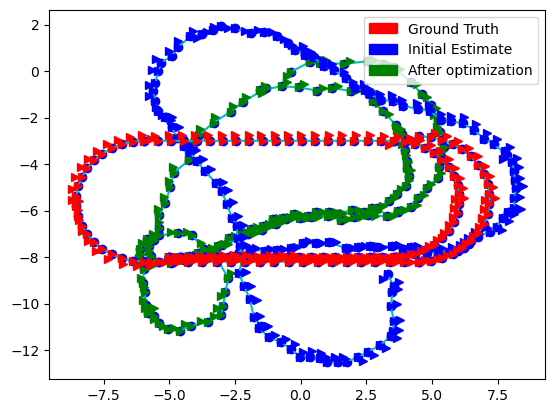

Iteration: 61
Error: 9311.533

Iteration: 62
Error: 22578.992

Iteration: 63
Error: 47298.086

Iteration: 64
Error: 61449.48

Iteration: 65
Error: 30358.875

Iteration: 66
Error: 12851.631

Iteration: 67
Error: 12768.117

Iteration: 68
Error: 14159.452

Iteration: 69
Error: 13952.249

Iteration: 70
Error: 8280.831


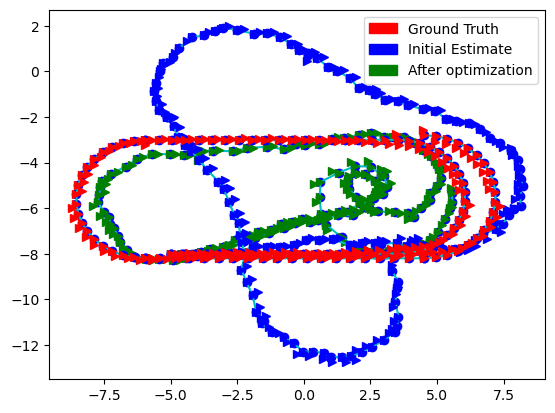

Iteration: 71
Error: 10776.417

Iteration: 72
Error: 21831.06

Iteration: 73
Error: 21342.504

Iteration: 74
Error: 16698.188

Iteration: 75
Error: 10659.35

Iteration: 76
Error: 5510.328

Iteration: 77
Error: 2505.8816

Iteration: 78
Error: 1312.3091

Iteration: 79
Error: 966.4164

Iteration: 80
Error: 879.3949


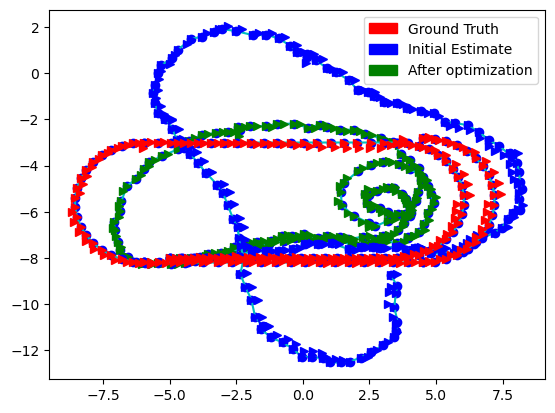

In [16]:
odo_certainity = 500
loop_certainity = 5000
start_certainity = 5000
max_itr = 80

poses_history, errors_history = optimise_lm(poses, 
                                            edges, 
                                            poses[0, :], 
                                            max_itr, 
                                            odo_certainity, 
                                            loop_certainity, 
                                            start_certainity,
                                            True)


Results for Information values = 500, 5000, 5000


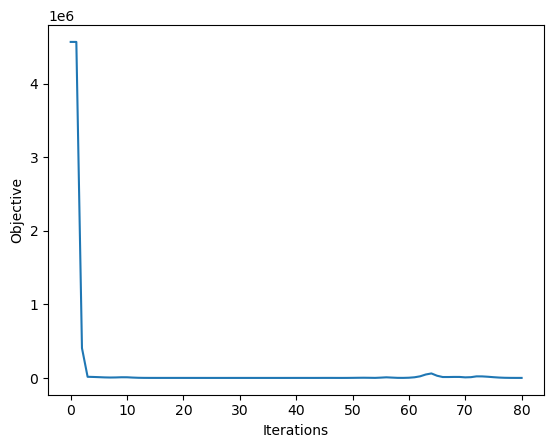


Best result:
Error: 664.44446


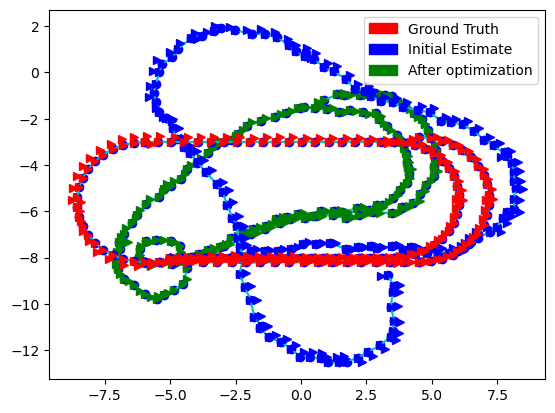

In [17]:
print("\nResults for Information values = 500, 5000, 5000")
plt.clf()
plt.plot(errors_history)
plt.xlabel('Iterations')
plt.ylabel('Objective')
plt.show()
best = jnp.argmin(jnp.asarray(errors_history))
print("\nBest result:")
print("Error: "+str(errors_history[best]))
draw_traj(poses_history[best][:, 0], poses_history[best][:, 1], poses_history[best][:, 2])

Iteration: 0
Error: 4566943.0


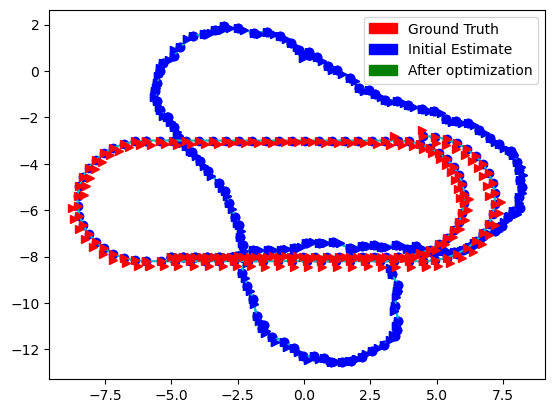

Iteration: 1
Error: 4566943.0

Iteration: 2
Error: 633109.06

Iteration: 3
Error: 12595.941

Iteration: 4
Error: 21393.832

Iteration: 5
Error: 12370.404

Iteration: 6
Error: 36798.02

Iteration: 7
Error: 84300.45

Iteration: 8
Error: 96675.42

Iteration: 9
Error: 5176.632

Iteration: 10
Error: 254.32503


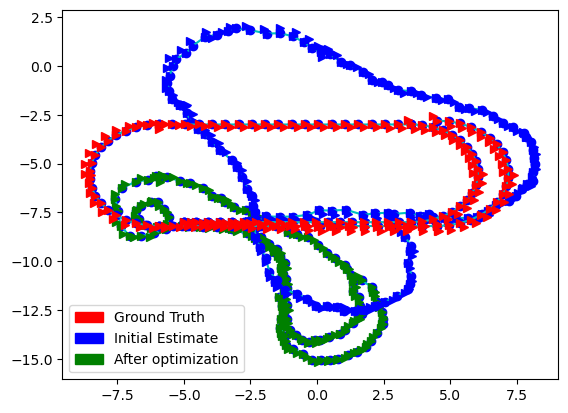

Iteration: 11
Error: 205.7249

Iteration: 12
Error: 231.65237

Iteration: 13
Error: 235.16844

Iteration: 14
Error: 164.32906

Iteration: 15
Error: 145.4356

Iteration: 16
Error: 243.89124

Iteration: 17
Error: 273.24225

Iteration: 18
Error: 158.37448

Iteration: 19
Error: 110.40116

Iteration: 20
Error: 145.65439


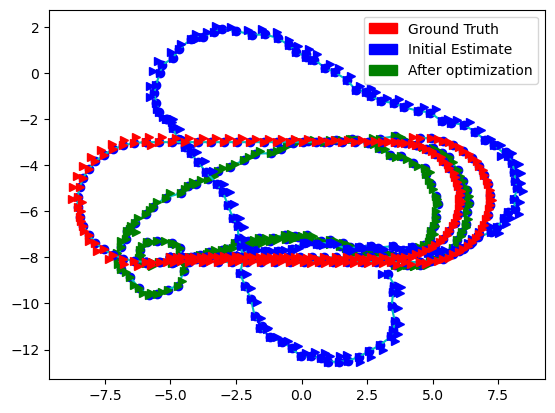

Iteration: 21
Error: 178.52864

Iteration: 22
Error: 188.29988

Iteration: 23
Error: 196.81712

Iteration: 24
Error: 184.51518

Iteration: 25
Error: 146.5868

Iteration: 26
Error: 129.14148

Iteration: 27
Error: 88.37051

Iteration: 28
Error: 75.03729

Iteration: 29
Error: 87.8436

Iteration: 30
Error: 82.697624


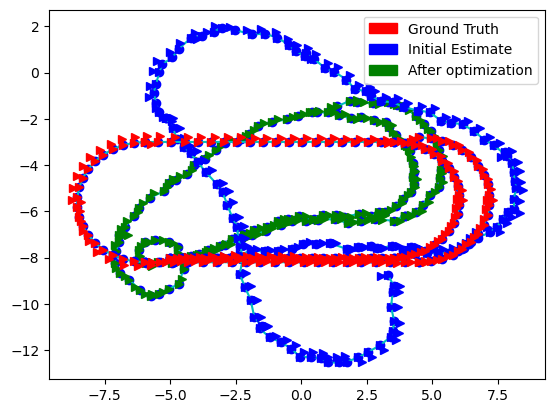

Iteration: 31
Error: 68.23319

Iteration: 32
Error: 90.92583

Iteration: 33
Error: 171.5702

Iteration: 34
Error: 269.35843

Iteration: 35
Error: 295.45554

Iteration: 36
Error: 191.97855

Iteration: 37
Error: 84.688705

Iteration: 38
Error: 253.82928

Iteration: 39
Error: 621.7625

Iteration: 40
Error: 626.9258


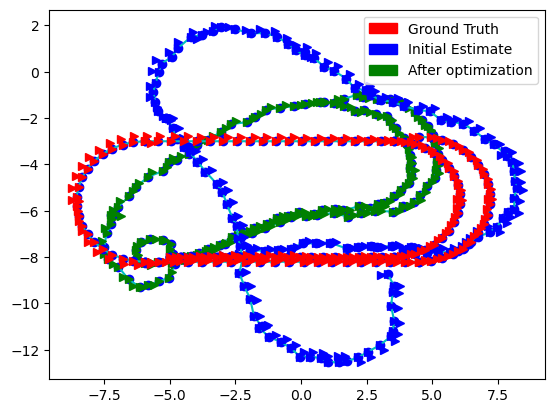

Iteration: 41
Error: 256.4864

Iteration: 42
Error: 87.42777

Iteration: 43
Error: 421.18967

Iteration: 44
Error: 1281.3364

Iteration: 45
Error: 2483.5645

Iteration: 46
Error: 3273.2695

Iteration: 47
Error: 2227.0918

Iteration: 48
Error: 214.47952

Iteration: 49
Error: 4343.4385

Iteration: 50
Error: 10866.923


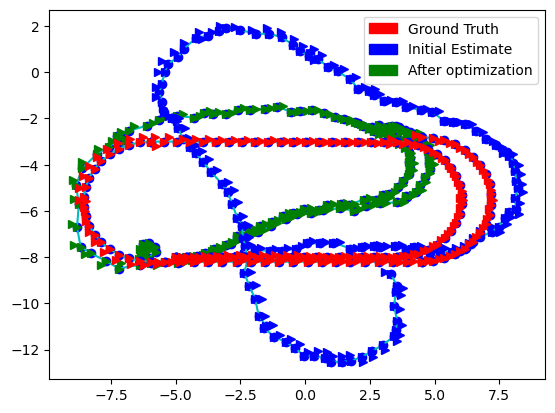

Iteration: 51
Error: 5716.457

Iteration: 52
Error: 738.83905

Iteration: 53
Error: 323.96384

Iteration: 54
Error: 2088.5674

Iteration: 55
Error: 7233.004

Iteration: 56
Error: 19494.928

Iteration: 57
Error: 45194.055

Iteration: 58
Error: 66652.58

Iteration: 59
Error: 33706.86

Iteration: 60
Error: 11491.7


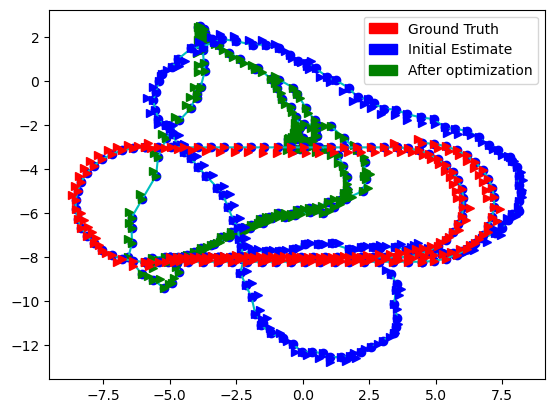

Iteration: 61
Error: 9823.695

Iteration: 62
Error: 7289.963

Iteration: 63
Error: 1185.7672

Iteration: 64
Error: 14062.6

Iteration: 65
Error: 19795.865

Iteration: 66
Error: 18667.162

Iteration: 67
Error: 13328.893

Iteration: 68
Error: 7544.1914

Iteration: 69
Error: 3265.753

Iteration: 70
Error: 1118.2555


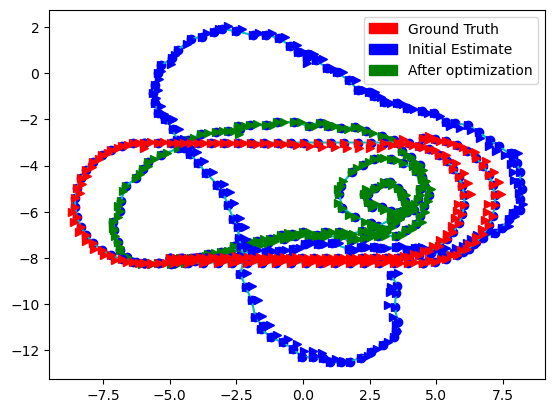

Iteration: 71
Error: 372.35916

Iteration: 72
Error: 169.89142

Iteration: 73
Error: 117.115036

Iteration: 74
Error: 100.83716

Iteration: 75
Error: 94.073715

Iteration: 76
Error: 90.45573

Iteration: 77
Error: 88.2784

Iteration: 78
Error: 86.922134

Iteration: 79
Error: 86.073204

Iteration: 80
Error: 85.54119


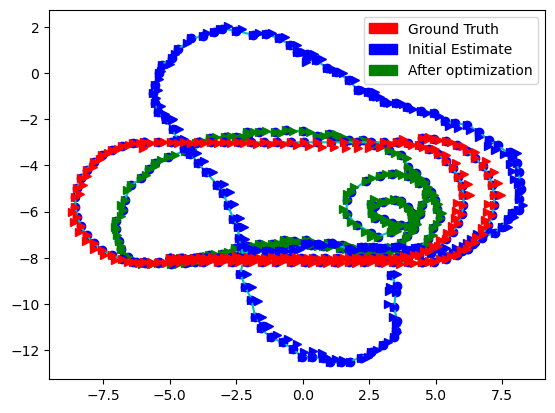

In [18]:
odo_certainity = 50
loop_certainity = 5000
start_certainity = 5000
max_itr = 80

poses_history, errors_history = optimise_lm(poses, 
                                            edges, 
                                            poses[0, :], 
                                            max_itr, 
                                            odo_certainity, 
                                            loop_certainity, 
                                            start_certainity,
                                            True)


Results for Information values = 50, 5000, 5000


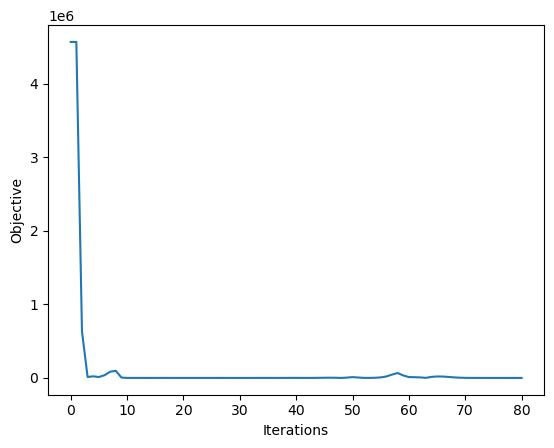


Best result:
Error: 68.23319


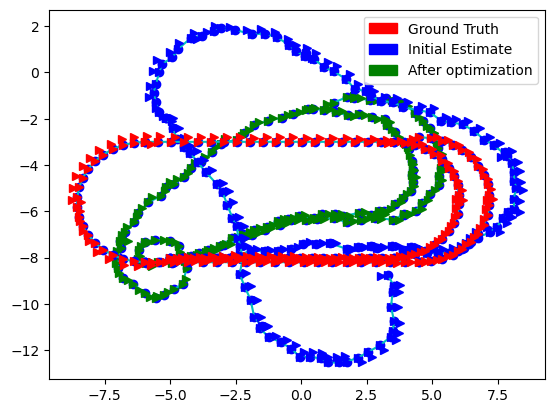

In [19]:
print("\nResults for Information values = 50, 5000, 5000")
plt.clf()
plt.plot(errors_history)
plt.xlabel('Iterations')
plt.ylabel('Objective')
plt.show()
best = jnp.argmin(jnp.asarray(errors_history))
print("\nBest result:")
print("Error: "+str(errors_history[best]))
draw_traj(poses_history[best][:, 0], poses_history[best][:, 1], poses_history[best][:, 2])

In [20]:
# Above weights seem to work well so we will save them.

with open('opt.g2o', 'w') as f:
    for i in range(poses_history[best].shape[0]):
        ind = i
        x = poses_history[best][i][0]
        y = poses_history[best][i][1]
        theta = poses_history[best][i][2]
        ln = "VERTEX_SE2 " + str(ind) + " " + str(x) + " " + str(y) + " " + str(theta)
        f.write("%s\n" % ln)
        
    for line in open('../data/edges.txt'):
        if "VERTEX_SE2" not in line:
            f.write("%s" % line)
                
f.close()

Iteration: 0
Error: 456694.38


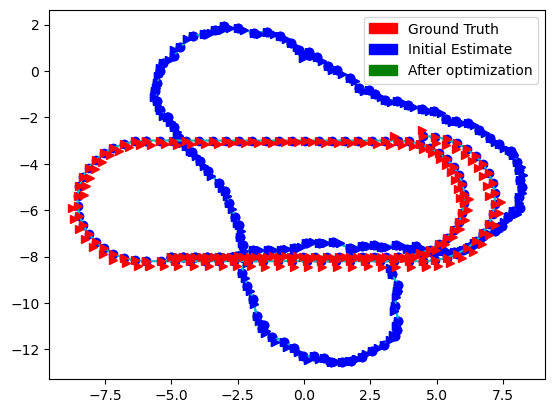

Iteration: 1
Error: 456694.38

Iteration: 2
Error: 80178.88

Iteration: 3
Error: 4080.036

Iteration: 4
Error: 3932.9832

Iteration: 5
Error: 1145.7797

Iteration: 6
Error: 438.24753

Iteration: 7
Error: 3567.8328

Iteration: 8
Error: 3461.1523

Iteration: 9
Error: 3304.5706

Iteration: 10
Error: 2921.5479


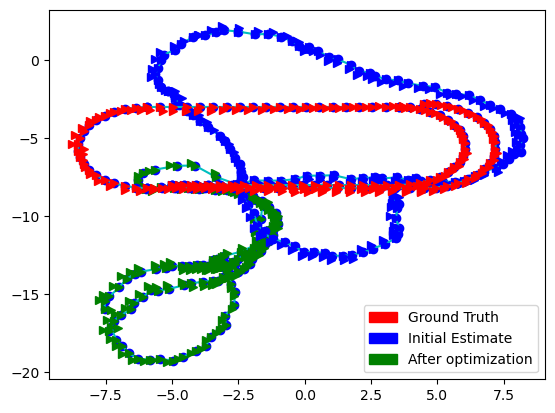

Iteration: 11
Error: 5583.7065

Iteration: 12
Error: 6917.946

Iteration: 13
Error: 906.6531

Iteration: 14
Error: 101.68227

Iteration: 15
Error: 43.527676

Iteration: 16
Error: 26.290024



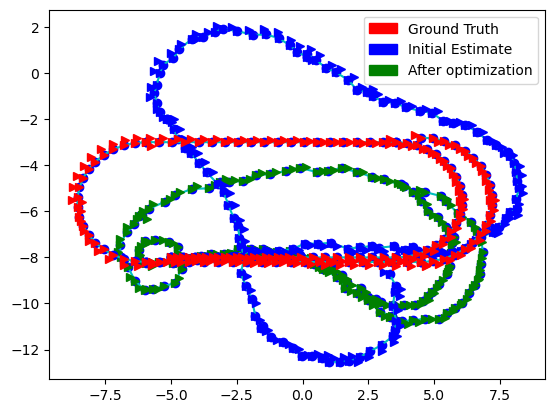

In [22]:
odo_certainity = 10
loop_certainity = 500
start_certainity = 1000
max_itr = 80

poses_history, errors_history = optimise_lm(poses, 
                                            edges, 
                                            poses[0, :], 
                                            max_itr, 
                                            odo_certainity, 
                                            loop_certainity, 
                                            start_certainity,
                                            True)


Results for Information values = 10, 500, 1000


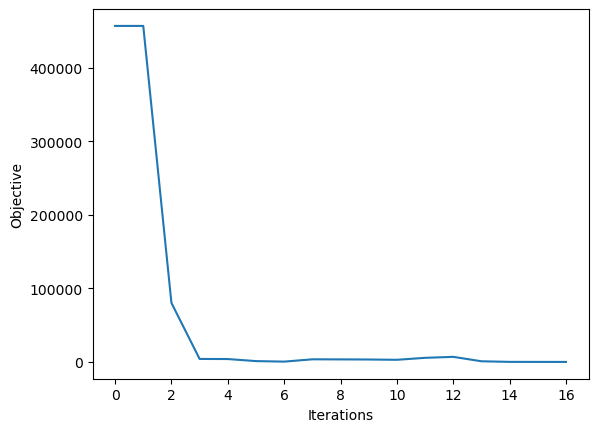


Best result:
Error: 26.290024


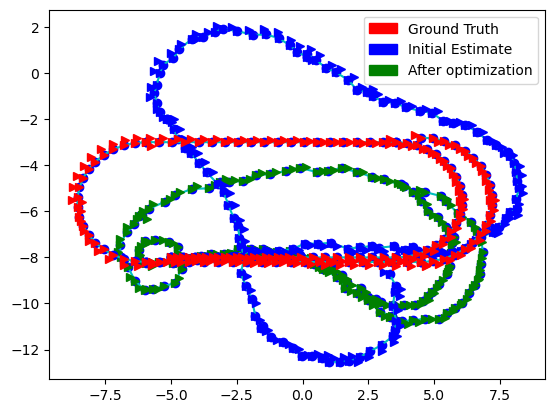

In [23]:
print("\nResults for Information values = 10, 500, 1000")
plt.clf()
plt.plot(errors_history)
plt.xlabel('Iterations')
plt.ylabel('Objective')
plt.show()
best = jnp.argmin(jnp.asarray(errors_history))
print("\nBest result:")
print("Error: "+str(errors_history[best]))
draw_traj(poses_history[best][:, 0], poses_history[best][:, 1], poses_history[best][:, 2])

Out of all the information values we have tested with 10, 500, 1000 gives the least numerical value for the objective. However, this might be skewed due to the numerically smaller value of the weights. Hence, we have saved the g2o file for 50, 5000, 5000 which seems to be the next best set.

**Tip**

Be sure to make your code modular and implement this in various stages. It will help you debug errors. Feel free to create helper functions in other files, just be sure to submit those as well. 

You are free to optimise your code using numba/Jax/torch if you wish, just ensure that you are not using any built in functions for any of the steps. It is only compulsory to verify your Jacobian using Jax.

## Part 3

- Write about the residuals you computed, its structure and shape. Also explain the structure of the Jacobian and its shape (Express the shape in terms of the number of vertices, loop constraints, and such, not exact numbers). 
- Write about the optimization process and any observations using intermediate plots and such. 

**Residuals**  
The residual is a column vector. and holds residual value of x, y and theta for each of the constraints. For each constraint, the residue of x, y, and theta have been stored in consecutive rows starting with residue of x. Also, since the anchor is the first constraint, the first 3 rows of the column vector are based on that. Then onwards, group of rows of the column vector represent the residue corresponding edge of the g2o file.  
Therefore, shape = [ (Number of edges in g2o file + 1) * 3, 1].
  
**Jacobian**  
The jacobian is a very sparse matrix and hence we have initialised it as a 0 matrix and adjusted the terms wherever required. It is simply the differentiation of each of the rows we get from the constrants with respect to all the variables (that is x, y, theta of all the vertices). Hence number of rows will be same as the number of rows in the residual and number of columns will be equal to 3 * number of poses.  
Therefore, shape = [ (Number of edges in g2o file + 1) * 3, (Number of vertices) * 3].  
For each row from g2o, we have to write the differentiation of the corresponding constraint with respect to each of the variables. Since very few variables are involved in a constraint, hence most of the elements of the row would be zero. A simple `-1` would be present for the x, y, theta in subtraction part of the constraint. A simple `1` would be present for x, y, theta for postive part of the constraint. Except these, there would also be two x and y transformation related terms, when differentiated with respect to theta. 
  
**About the optimization process and any observations using intermediate plots**  
* We tried the optimisation using LM optimizer with different information values as required.  
* One important observation is that the plots took much more iterations compared to the least squares optimizations done during assignment 3. However, the errors usually didn't improve much after ~80 iterations.
* Also, some times the error shot up and then came back down. Hence, the best error wasn't equal to the error of the last iteration in any of the cases.  
* Also, the noise in loop closures seem to be lesser compared to the odometry as when the weights for loop closure and anchor were kept much higher than the odometry weights, then the error was much smaller.
* Due to the errors in the constraints, the poses never exactly converged to the ground truth.

## Part 4

Write the final optimised trajectory as a g2o file. You can do this alongside any of the earlier parts.

In [ ]:
# Done already when ran with information values = [50, 5000, 5000]